In [9]:
# German Credit Risk Analysis with XGBoost and SMOTE

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [10]:
# Load the data
column_names = [
    'checking_account', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings_account', 'employment', 'installment_rate', 'personal_status_sex',
    'other_debtors', 'residence_since', 'property', 'age', 'other_installment_plans',
    'housing', 'existing_credits', 'job', 'dependents', 'telephone', 'foreign_worker',
    'credit_risk'
]

df = pd.read_csv('german.data', sep=' ', header=None, names=column_names)

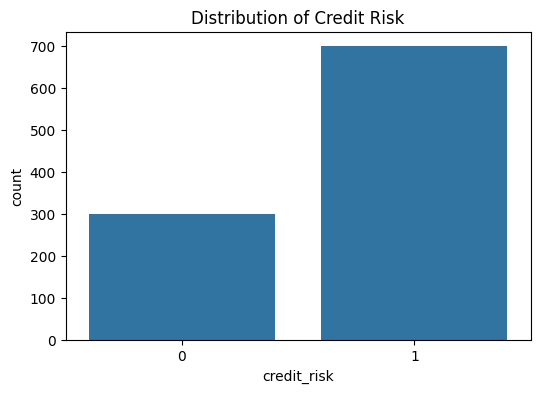

In [11]:
# Convert target variable to binary
df['credit_risk'] = df['credit_risk'].map({1: 1, 2: 0})

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='credit_risk', data=df)
plt.title('Distribution of Credit Risk')
plt.show()

In [12]:
# Encode categorical variables
categorical_cols = [
    'checking_account', 'credit_history', 'purpose', 'savings_account',
    'employment', 'personal_status_sex', 'other_debtors', 'property',
    'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker'
]


In [13]:

mappings = {}
for col in categorical_cols:
    unique_vals = df[col].unique()
    mappings[col] = {val: idx for idx, val in enumerate(unique_vals)}
    df[col] = df[col].map(mappings[col])

# Save mappings for use in future deployments
joblib.dump(mappings, 'category_mappings.pkl')

['category_mappings.pkl']

In [14]:
# Split features and target
X = df.drop('credit_risk', axis=1)
y = df['credit_risk']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [15]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [16]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

Fitting 5 folds for each of 36 candidates, totalling 180 fits

✅ Accuracy: 0.825

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82       131
           1       0.85      0.82      0.83       149

    accuracy                           0.82       280
   macro avg       0.82      0.83      0.82       280
weighted avg       0.83      0.82      0.83       280


🧮 Confusion Matrix:
 [[109  22]
 [ 27 122]]


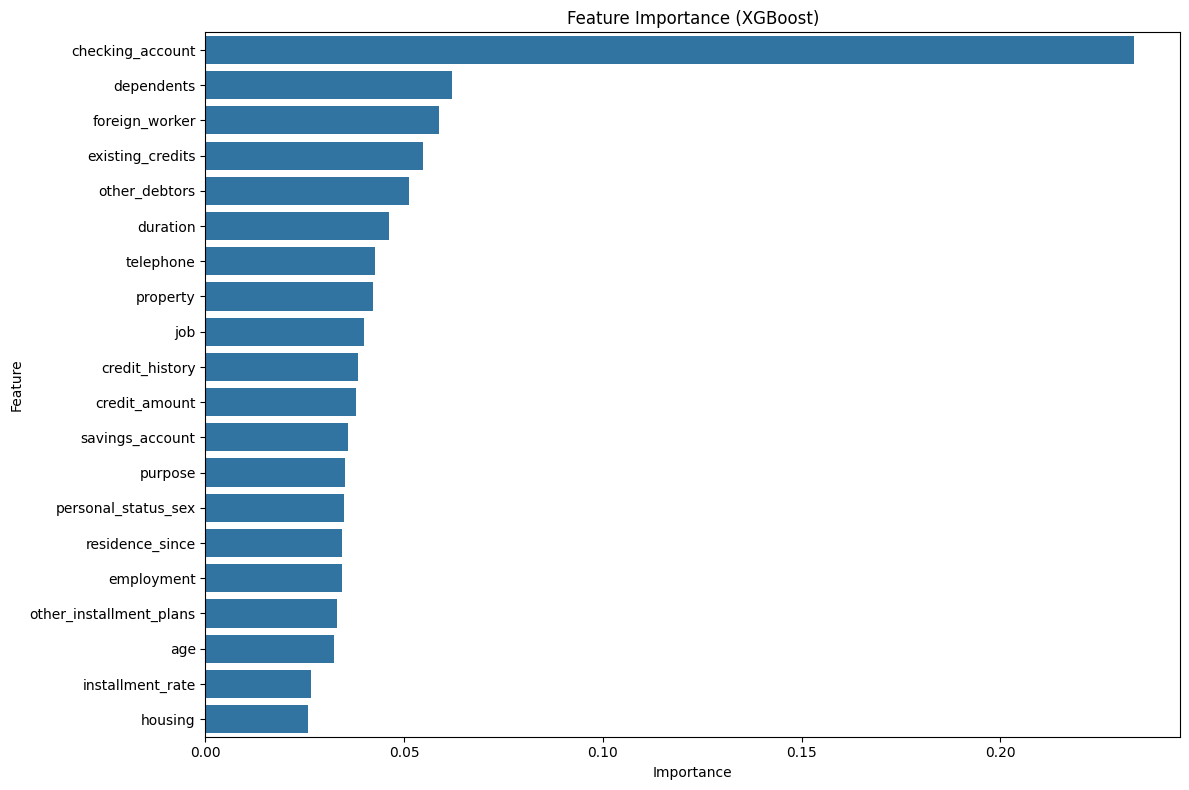

In [17]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best model
best_xgb = grid_search.best_estimator_

# Save the model
joblib.dump(best_xgb, 'credit_risk_model_xgb.pkl')

# Predictions
y_pred = best_xgb.predict(X_test_scaled)

# Evaluation
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()
